# Predicting who will survive Titanic

**Source**
- Kaggle Challenge: https://www.kaggle.com/competitions/titanic/overview

**Main Goal**
- Create a model that predicts which passengers survived the Titanic shipwreck

**Honourable objectives**
- Familiarize in a practial way with Machine Learning
- Compare the usage of normal methods with an Ensamble approach

# Summary

1. Initialization
2. Variable Description
3. Data Treatment
   1. Dropping Irrelevant Information
   2. Outliers
   3. Imputing Missing Variables
   4. Transforming Distribuitions
4. Bivariable Analysis
5. Feature Engineering
6. Machine Learning and Performance Evaluation
7. Ensamble Learning

# 1. Initialization

In [1]:
'''Ignore deprecation and future, and user warnings.'''
import warnings as wrn
wrn.filterwarnings('ignore', category = DeprecationWarning) 
wrn.filterwarnings('ignore', category = FutureWarning) 
wrn.filterwarnings('ignore', category = UserWarning)

'''Import basic modules.'''
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
'''Customize visualization
Seaborn and matplotlib visualization.'''
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')                    
sns.set_style({'axes.grid':False}) 

'''Plotly visualization .'''
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected = True) # Required to use plotly offline in jupyter notebook

'''Display markdown formatted output like bold, italic bold etc.'''
from IPython.display import Markdown
def bold(string):
    display(Markdown(string))

In [3]:
'''Read in train and test data from csv files.'''
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

'''Auxiliary variable'''
last_train_id = 891

# 2. Variable Description

In [4]:
'''Train and test data at a glance.'''
bold('**Preview of Train Data:**')
display(train.head(3))
bold('**Preview of Test Data:**')
display(test.head(3))

**Preview of Train Data:**

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


**Preview of Test Data:**

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [5]:
'''Dimensions of train and test data'''
bold('**Shape of our train and test data:**')
display(train.shape, test.shape)

**Shape of our train and test data:**

(891, 12)

(418, 11)

In [6]:
'''Have a look of our variable names'''
bold('**Name of our variables**')
display(train.columns.values)

**Name of our variables**

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

Joining _train_ and _test_ datasets to treat them at the same time and same some code and time

In [7]:
"""Let's first inspect how many kinds of data types that we have to deal with."""
merged = pd.concat([train, test], axis = 0, sort = True)
bold('**Data types of our variables:**')
display(merged.dtypes.value_counts())

**Data types of our variables:**

object     5
int64      4
float64    3
dtype: int64

In [8]:
'''Extract numerical variables first.'''
num_merged = merged.select_dtypes(include = ['int64', 'float64'])
bold('**Numerical variables:**')
display(num_merged.head(3))
bold('**Name of numerical variables:**')
display(num_merged.columns.values)

**Numerical variables:**

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
0,22.0,7.2500,0,1,3,1,0.0
1,38.0,71.2833,0,2,1,1,1.0
2,26.0,7.9250,0,3,3,0,1.0


**Name of numerical variables:**

array(['Age', 'Fare', 'Parch', 'PassengerId', 'Pclass', 'SibSp',
       'Survived'], dtype=object)

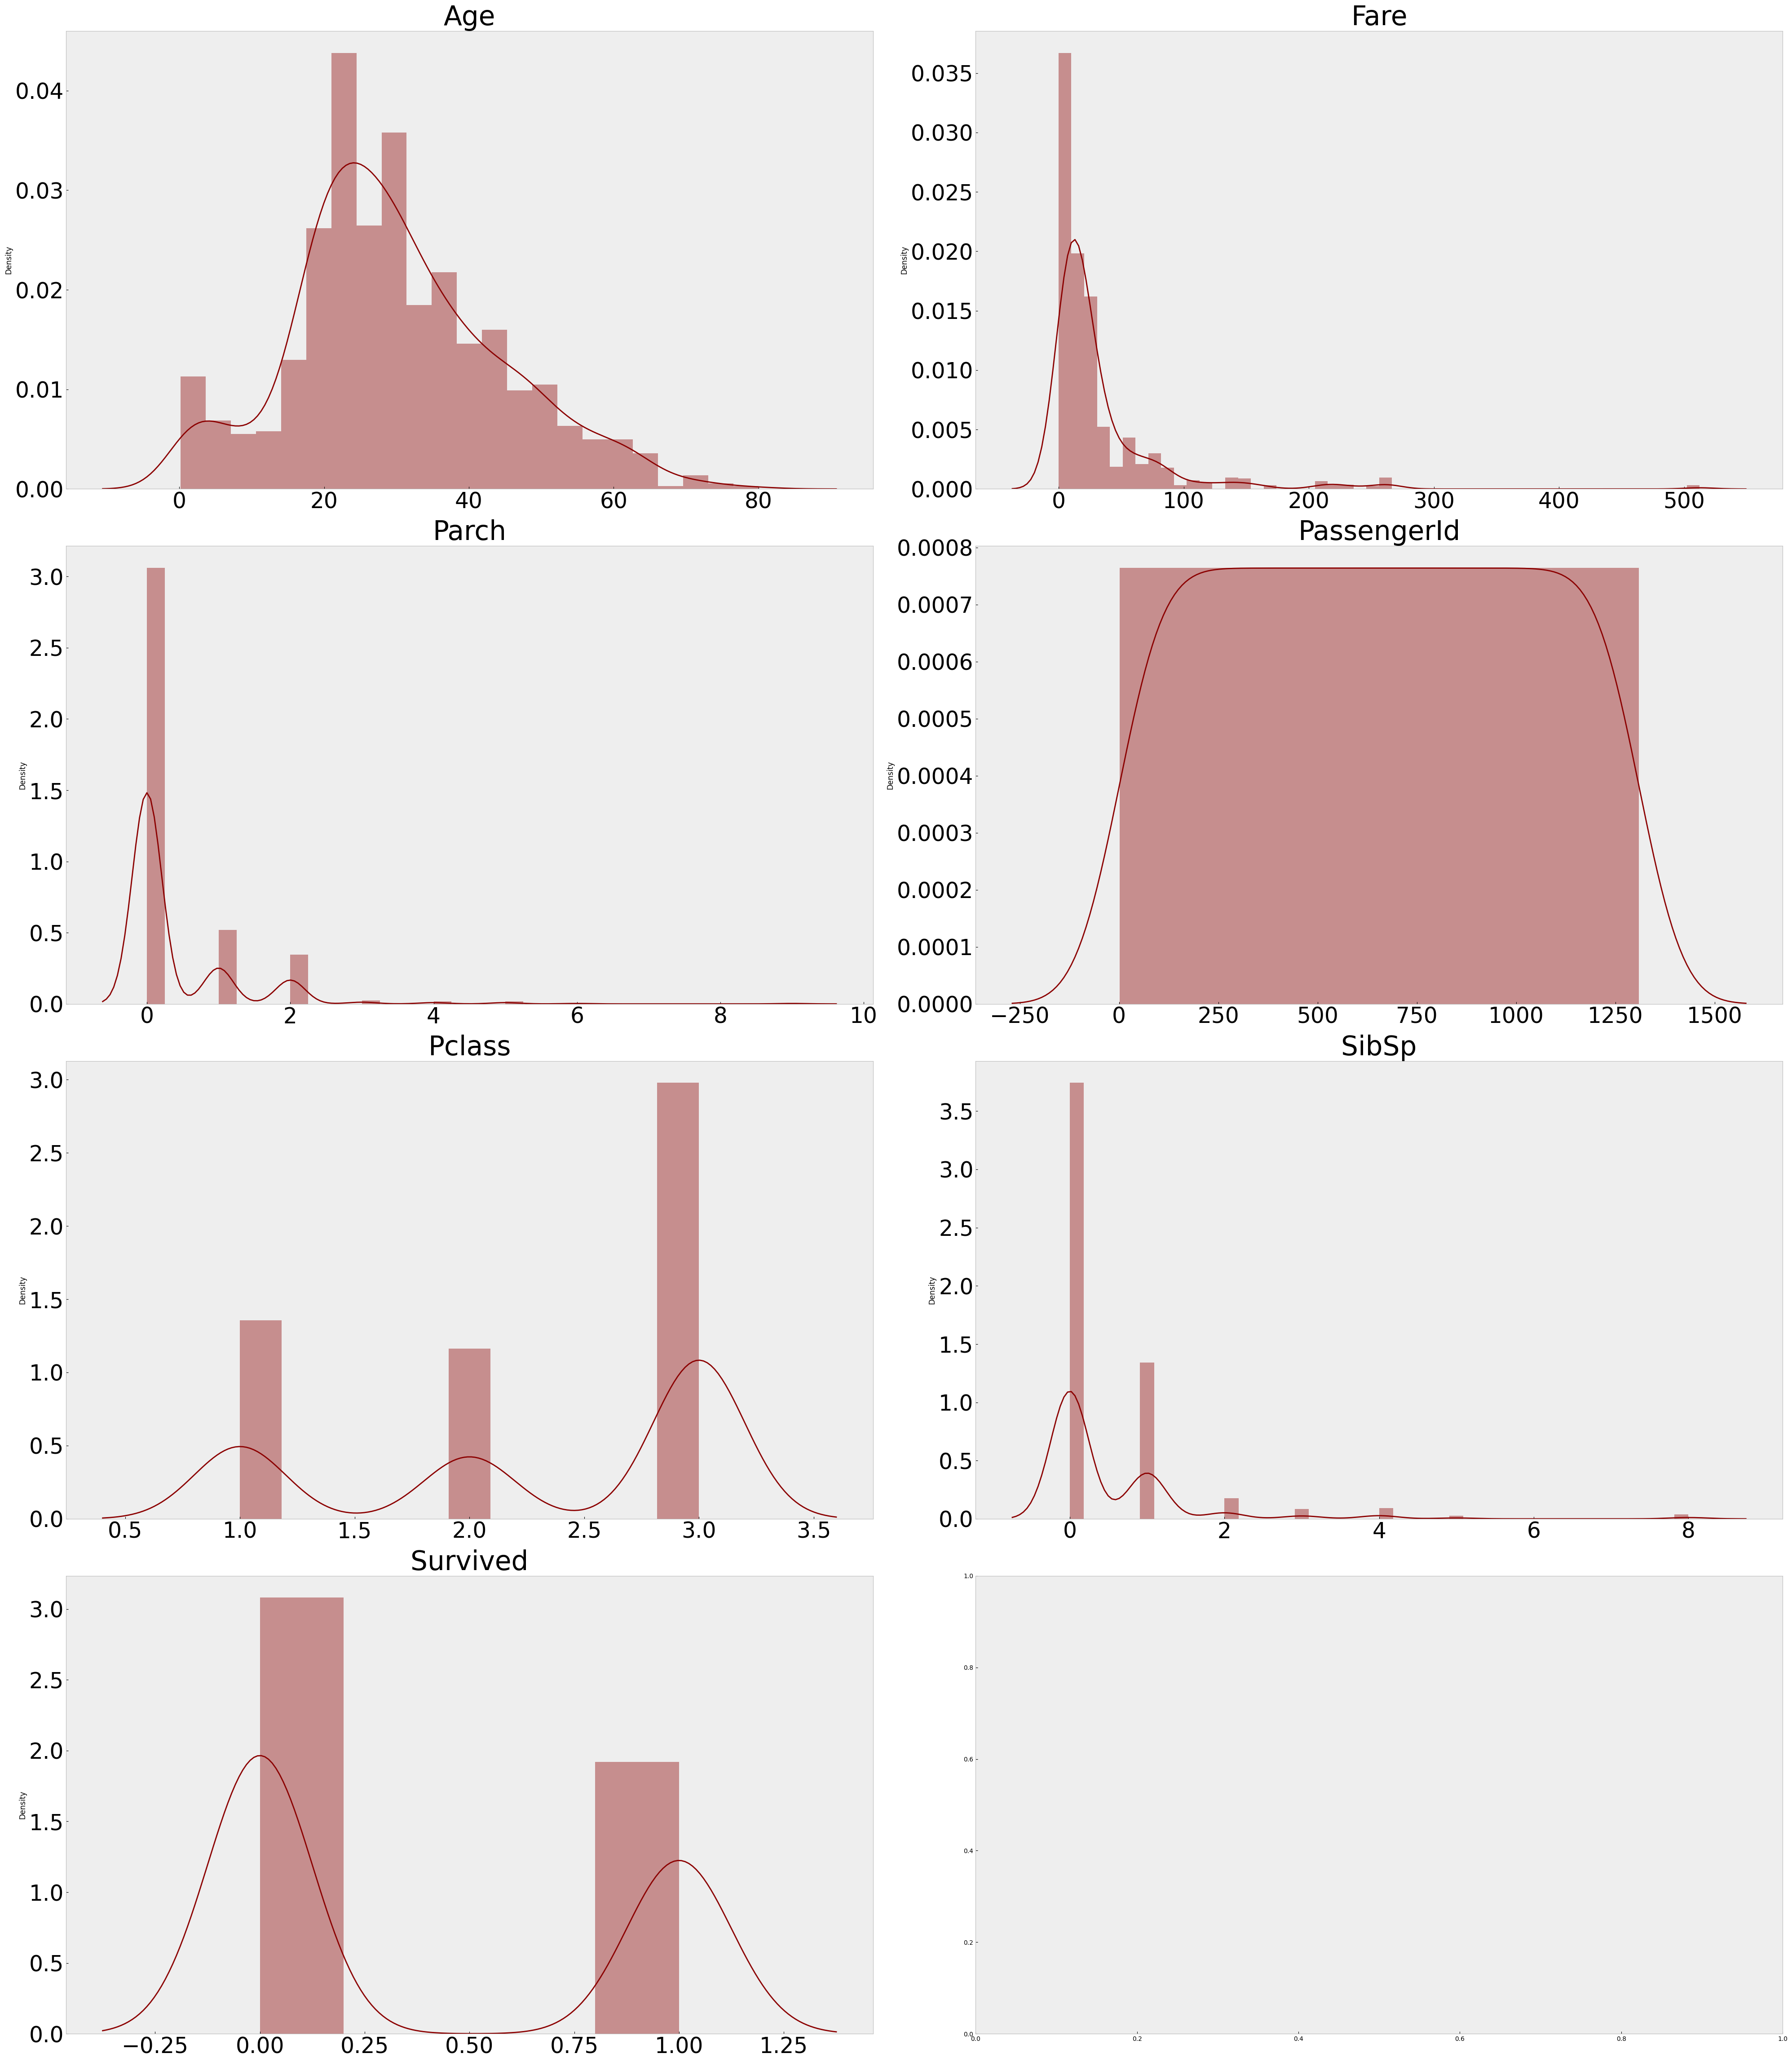

In [9]:
'''Plot histogram of numerical variables to validate pandas intuition.'''
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (40, 50))
for ax, column in zip(axes.flatten(), num_merged.columns):
    sns.distplot(num_merged[column].dropna(), ax = ax, color = 'darkred')
    ax.set_title(column, fontsize = 43)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 35)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 35)
    ax.set_xlabel('')
fig.tight_layout(rect = [0, 0.03, 1, 0.95])

Variable analysis:
- Continuous: _Age, Fare, PassengerId_
- Discrete: _Parch, Pclass, SibSp, Survived_

In [10]:
'''Convert Parch, Pclass, SibSp, Survived into categorical variables.'''
merged.loc[:,['Parch', 'Pclass', 'SibSp', 'Survived']] = merged.loc[:,['Parch', 'Pclass', 'SibSp', 'Survived']].astype('object')

In [11]:
'''Check out the data types after correction'''
bold('**Data types after correction:**')
display(merged.dtypes.value_counts())

**Data types after correction:**

object     9
float64    2
int64      1
dtype: int64

In [12]:
'''Extract train and test data from the combined data set.'''
df_train = merged.iloc[:last_train_id, :].drop(columns = ['PassengerId'], axis = 1)
df_test = merged.iloc[last_train_id:, :].drop(columns = ['PassengerId', 'Survived'], axis = 1) # Survived due to concatenation

# 3. Data Treatment

In [13]:
'''Function to plot bar chart'''
def bar_plot(x, y, title, yaxis, c_scale):
    trace = go.Bar(
    x = x,
    y = y,
    marker = dict(color = y, colorscale = c_scale))
    layout = go.Layout(hovermode= 'closest', title = title, yaxis = dict(title = yaxis))
    fig = go.Figure(data = [trace], layout = layout)
    return iplot(fig)

'''Function to plot scatter plot'''
def scatter_plot(x, y, title, xaxis, yaxis, size, c_scale):
    trace = go.Scatter(
    x = x,
    y = y,
    mode = 'markers',
    marker = dict(color = y, size = size, showscale = True, colorscale = c_scale))
    layout = go.Layout(hovermode= 'closest', title = title, xaxis = dict(title = xaxis), yaxis = dict(title = yaxis))
    fig = go.Figure(data = [trace], layout = layout)
    return iplot(fig)    
    
'''Function to plot histogram'''
def plot_histogram(x, title, yaxis, color):
    trace = go.Histogram(x = x,
                        marker = dict(color = color))
    layout = go.Layout(hovermode= 'closest', title = title, yaxis = dict(title = yaxis))
    fig = go.Figure(data = [trace], layout = layout)
    return iplot(fig)

## 3.1 Dropping Irrelevant Information

Some data present in our database is not interesting for our study because it is logicaly irrelevant for the outocme, therefore it should be dropped. 

The _Name_ of a person; his _Ticket_ number are unique for each passenger so they need to be out.

In [14]:
'''Dropping Name column.'''
df_train = df_train.drop(columns = ['Name'], axis = 1)
df_test = df_test.drop(columns = ['Name'], axis = 1)

'''Dropping Ticket column.'''
df_train = df_train.drop(columns = ['Ticket'], axis = 1)
df_test = df_test.drop(columns = ['Ticket'], axis = 1)

## 3.2 Outliers

Since all the result information is boolean, there can only by a 0 or 1 result, so outliers aren't a problem in our dataset.

If we had a distribution as a result, a scatter plot would be useful to see which data is an outlier.

## 3.3 Imputing Missing Variables

The simpliest way to impute missing values of a variable is to use its mean, median or mode depending on its distribution and variable type (categorical or numerical). For categorical variables mode-imputation is performed and for numerical variable mean-impuation is performed if its distribution is symmetric(or almost symmetric or normal like Age). On the other hand, for a variable with skewed distribution and outliers, meadian-imputation is recommended as median is more immune to outliers than mean.

However, one clear disadvantage of using mean, median or mode to impute missing values is the addition of bias if the amount of missing values is significant. So simply replacing missing values with the mean or the median might not be the best solution since missing values may differ by groups and categories. To solve this, we can group our data by some variables that have no missing values and for each subset compute the median to impute the missing values of a variable. 

**For this purpose we would merge train and test data together. This will eliminate the hassle of handling train and test data separately thought it might induce some data leakage problem. But in practice, we would not have any test data during model training, so data leakage problem in real world could be avoided. Moreover, all the preprocessings done combinedly lead to better a leaderboard score (may be due ''to data leakage).**

In [15]:
'''Separate our target variable first.'''
y_train = df_train.Survived

'''Drop Survived from train data.'''
df_train.drop('Survived', axis = 1, inplace = True)

'''Now combine train and test data frame together.'''
df_merged = pd.concat([df_train, df_test], axis = 0)


In [16]:
'''Columns with missing observations.'''
missing_columns = df_merged.columns[df_merged.isnull().any()].values

'''Number of columns with missing observations.'''
total_columns = np.count_nonzero(df_merged.isna().sum())
print('We have ' , total_columns ,  'features with missing values and those features (with missing values) are: \n\n' , missing_columns)

We have  4 features with missing values and those features (with missing values) are: 

 ['Age' 'Cabin' 'Embarked' 'Fare']


In [17]:
'''Get and plot only the features (with missing values) and their corresponding missing values.'''
missing_columns = len(df_merged) - df_merged.loc[:, np.sum(df_merged.isnull())>0].count()
x = missing_columns.index
y = missing_columns
title = 'Variables with Missing Values'
scatter_plot(x, y, title, 'Features Having Missing Observations','Missing Values', 30, 'Picnic')

Usually we drop a variable if at least 40% of its values are missing, so from this chart we can see that the _Cabin_ information can be dropped.

In [18]:
'''Drop Cabin from merged data.'''
df_merged.drop('Cabin', axis = 1, inplace = True)

As for the other variables, we are going to inpute based on their characteristic
- Numerical (Median approach): _Age_*, _Fare_
- Categorical (Mode approach): _Embarked_

In [19]:
'''These are categorical variables and will be imputed by mode.'''
to_impute_by_mode = df_merged.loc[:, ['Embarked']]
for i in to_impute_by_mode.columns:
    df_merged[i].fillna(df_merged[i].mode()[0], inplace = True)

In [20]:
'''The following variables are either discrete numerical or continuous numerical variables.So the will be imputed by median.'''
to_impute_by_median = df_merged.loc[:, ['Fare']]
for i in to_impute_by_median.columns:
    df_merged[i].fillna(df_merged[i].median(), inplace = True)

In [21]:
'''Columns remaining to be imputed'''
display(df_merged.columns[df_merged.isna().any()].values)

array(['Age'], dtype=object)

*Since around **20%** of _Age_ observations are missing. Hence, simply imputing _Age_ by mean or median might introduce bias since the amount of missing values is significant. To solve this, we can group our data by some variables that have no missing values and for each subset compute the median _Age_ to impute the missing values of it. This method may result in better accuracy without high bias, unless a missing value is expected to have a very high variance.

In [22]:
"""Let's create a function to find the variables correlated with Age"""
def corr(correlation, variable):
    from sklearn.preprocessing import LabelEncoder # Convert categorical variables into numerical
    correlation = correlation.agg(LabelEncoder().fit_transform)
    correlation['Age'] = variable
    corr = correlation.corr()
    display(corr['Age'].sort_values(ascending = False))
    # display(corr['LotFrontage'].sort_values(ascending = False)[:5]) # if many variables, use these to see the Top +5/-5
    # display(corr['LotFrontage'].sort_values(ascending = False)[-5:])

In [23]:
'''Correlation of LotFrontage with categorical data.'''
bold("**Age's correlation with categorical data:**")
corr(df_merged.select_dtypes(include = ['object']), df_merged.Age)

**Age's correlation with categorical data:**

Age         1.000000
Sex         0.063645
Embarked   -0.080195
Parch      -0.150917
SibSp      -0.245152
Pclass     -0.408106
Name: Age, dtype: float64

_Pclass_ has the highest correlatin with _Age_. So the tatic is to impute missing values of _Age_ with the median _Age_ of similar rows according to _Pclass_

In [24]:
'''Impute LotFrontage with the median of highest correlated column(i.e., BldgType)'''
df_merged.Age = df_merged.groupby(['Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))

In [25]:
'''Is there any missing values left untreated??'''
print('Missing variables left untreated: ', df_merged.columns[df_merged.isna().any()].values)

Missing variables left untreated:  []


## 3.4 Transforming Distribuitions

Our goal with this last treatment is to reduce the skewness of a normal distribuition, to make our data fit better into a Normal Distribuition pattern.

--project temporarely stopped :(